In [55]:
import numpy as np
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [56]:
df =pd.read_csv('../danger_level.csv')
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 1073
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   processo_numero         990 non-null    object 
 1   solicitacao_data        990 non-null    object 
 2   solicitacao_hora        990 non-null    object 
 3   solicitacao_descricao   990 non-null    object 
 4   solicitacao_bairro      990 non-null    object 
 5   solicitacao_localidade  990 non-null    object 
 6   solicitacao_endereco    990 non-null    object 
 7   processo_ocorrencia     990 non-null    object 
 8   confirmado              990 non-null    int64  
 9   latitude                990 non-null    float64
 10  longitude               990 non-null    float64
 11  cond                    990 non-null    bool   
 12  em_recife               990 non-null    int64  
 13  rain_hour               990 non-null    float64
 14  rain_day                990 non-null    f

In [57]:
def label_ground_int(row):
    match row['ground_type']:
        case "LVd2":
            return 0 
        case "LVd4":
            return 1 
        case "A2":
            return 2 
        case "URBANO":
            return 3 
        case "PV1":
            return 4 
        case "HP":
            return 5 
        case "AGUA":
            return 6 
        case "ILHA":
            return 7 
def label_danger_int(row):
    match row['danger_level']:
        case 'Baixa':
            return 0 
        case 'Média':
            return 1 
        case 'Alta':
            return 2 

In [58]:

Target = ['confirmado']
Predictors = ['rain_hour', 'rain_day', 'altitude', 'ground_type_int', 'danger_level_int']
df['ground_type_int'] = df.apply(lambda row: label_ground_int(row), axis=1)
df['danger_level_int'] = df.apply(lambda row: label_danger_int(row), axis=1)

X = df[Predictors].values
y = df[Target].values



In [59]:
PredictorScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(X)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(693, 5)
(693, 1)
(297, 5)
(297, 1)


In [60]:
classifier = tf.keras.Sequential()
# Defining the Input layer and FIRST hidden layer,both are same!
# relu means Rectifier linear unit function
classifier.add(tf.keras.layers.Dense(units=10, input_dim=5, kernel_initializer='uniform', activation='relu'))

#Second layer
classifier.add(tf.keras.layers.Dense(units=6, kernel_initializer='uniform', activation='relu'))

# Defining the Output layer
# sigmoid means sigmoid activation function
# for Multiclass classification the activation ='softmax'
# And output_dim will be equal to the number of factor levels
classifier.add(tf.keras.layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

""" tensor = tf.convert_to_tensor(classifier)
 """
# fitting the Neural Network on the training data
X_train =  np.asarray(X_train).astype('float32')
y_train =  np.asarray(y_train).astype('float32')

print(classifier.summary())

survivalANN_Model=classifier.fit(X_train,y_train, batch_size=10 , epochs=10, verbose=1)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 10)                60        
                                                                 
 dense_44 (Dense)            (None, 6)                 66        
                                                                 
 dense_45 (Dense)            (None, 1)                 7         
                                                                 
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
70/70 [==============================] - 1s 3ms/step - loss: 0.6876 - accuracy: 0.6753
Epoch 2/10
70/70 [==============================] - 0s 2ms/step - loss: 0.6663 - accuracy: 0.6768
Epoch 3/10
70/70 [==============================] - 0s 2ms/step - loss: 0.6206 - accuracy: 0.6768
Epoch 4/10
70/70 [==

In [62]:
def FunctionFindBestParams(X_train, y_train):
    
    # Defining the list of hyper parameters to try
    TrialNumber=0
    batch_size_list=[5, 10, 15, 20]
    epoch_list=[5, 10, 50 ,100]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            
            # Creating the classifier ANN model
            classifier = tf.keras.Sequential()
            classifier.add(tf.keras.layers.Dense(units=10, input_dim=5, kernel_initializer='uniform', activation='relu'))
            classifier.add(tf.keras.layers.Dense(units=6, kernel_initializer='uniform', activation='relu'))
            classifier.add(tf.keras.layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
            classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
            
            survivalANN_Model=classifier.fit(X_train,y_train, batch_size=batch_size_trial , epochs=epochs_trial, verbose=0)
            # Fetching the accuracy of the training
            Accuracy = survivalANN_Model.history['accuracy'][-1]
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', Accuracy)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,
                            'batch_size'+str(batch_size_trial)+'-'+'epoch'+str(epochs_trial), Accuracy]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 
###############################################
 
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.6868686676025391


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.7128427028656006


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.7489177584648132


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 0.7647907733917236


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.6767676472663879


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.7041847109794617


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.7546897530555725


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 0.7445887327194214


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.6767676472663879


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.6767676472663879


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.7503607273101807


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 0.7503607273101807


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.6767676472663879


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.6767676472663879


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


15 Parameters: batch_size: 20 - epochs: 50 Accuracy: 0.7330447435379028


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


16 Parameters: batch_size: 20 - epochs: 100 Accuracy: 0.7532467246055603


C:\Users\parae\AppData\Local\Temp\ipykernel_8808\3545517515.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,


  TrialNumber            Parameters  Accuracy
0           4  batch_size5-epoch100  0.764791


<AxesSubplot:xlabel='Parameters'>

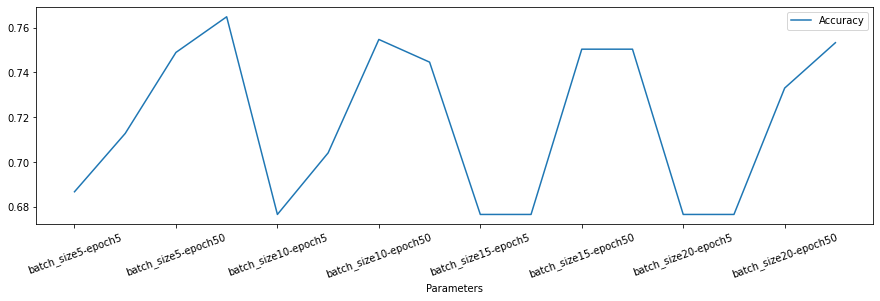

In [63]:

# Printing the best parameter
print(ResultsData.sort_values(by='Accuracy', ascending=False).head(1))
 
# Visualizing the results
%matplotlib inline
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line', rot=20)

In [69]:
# Training the model with best hyperparamters
classifier.fit(X_train,y_train, batch_size=20, epochs=50, verbose=1)

Epoch 1/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5065 - accuracy: 0.7590
Epoch 2/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5064 - accuracy: 0.7605
Epoch 3/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5065 - accuracy: 0.7619
Epoch 4/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5065 - accuracy: 0.7605
Epoch 5/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5064 - accuracy: 0.7561
Epoch 6/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5064 - accuracy: 0.7605
Epoch 7/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5062 - accuracy: 0.7605
Epoch 8/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5063 - accuracy: 0.7590
Epoch 9/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5063 - accuracy: 0.7619
Epoch 10/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5065 - accuracy: 0.7605
Epoch 11/50
35/35 [

In [76]:
Predictions=classifier.predict(X_test)
 
# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)
 
# Generating a data frame for analyzing the test data
TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Confirmado']=y_test
TestingData['Predicted_confirmado']=Predictions
 
# Defining the probability threshold
def probThreshold(inpProb):
    if inpProb > 0.7:
        return(1)
    else:
        return(0)
 
# Generating predictions on the testing data by applying probability threshold
TestingData['Predicted_confirmado']=TestingData['Predicted_confirmado'].apply(probThreshold)
print(TestingData.head())
 
###############################################
from sklearn import metrics
print('\n######### Testing Accuracy Results #########')
print(metrics.classification_report(TestingData['Confirmado'], TestingData['Predicted_confirmado']))
print(metrics.confusion_matrix(TestingData['Confirmado'], TestingData['Predicted_confirmado']))


10/10 [==============================] - 0s 3ms/step
   rain_hour      rain_day  altitude  ground_type_int  danger_level_int  \
0        0.0  7.000000e+00      35.0              4.0               1.0   
1        0.2  4.100000e+00      72.0              2.0               1.0   
2        0.3  8.100000e+00       9.0              2.0               0.0   
3        8.2  8.400000e+01      25.0              1.0               0.0   
4        0.0  3.552714e-15      11.0              0.0               0.0   

   Confirmado  Predicted_confirmado  
0           1                     0  
1           0                     0  
2           0                     0  
3           1                     0  
4           0                     0  

######### Testing Accuracy Results #########
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       203
           1       0.00      0.00      0.00        94

    accuracy                           0.68       297
   m

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
